In [1]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from model import UNET
from dataloader import get_loaders_heatmaps
import FILE_PATHS
import pandas as pd
import numpy as np
from training_landmarks import(
    train, 
    plot_loss_curves
)


In [2]:
# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
NUM_EPOCHS = 5
NUM_WORKERS = 4
IMAGE_HEIGHT = 112
IMAGE_WIDTH = 112
PIN_MEMORY = True
LOAD_MODEL = False


In [3]:
# Transformations
train_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        # A.Rotate(limit=35, p=1.0),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

In [4]:
# MODEL
model = UNET(in_channels=3, out_channels=7).to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model_type = "landmarks"

In [5]:
# BATCHES
train_loader, val_loader = get_loaders_heatmaps(
    FILE_PATHS.IMAGES,
    f"{FILE_PATHS.HEATMAPS}/gaussian",
    FILE_PATHS.MASKS,
    BATCH_SIZE,
    train_transforms,
    val_transforms,
    NUM_WORKERS,
    test_size=0.2,
    seed=42,
)

TRAIN PATHS LENGTHS: images, masks, heatmaps
800, 800, 800
VALIDATION PATHS LENGTHS: images, masks, heatmaps
200, 200, 200


In [6]:
import cv2
import matplotlib.pyplot as plt

In [7]:

def sort_coordinates(coordinates):
    coordinates = np.array(coordinates)
    centroid = np.mean(coordinates, axis=0)
    x = coordinates[:, 0]
    y = coordinates[:, 1]
    angles = np.arctan2(y - centroid[1], x - centroid[0])
    sorted_indices = np.argsort(angles)
    sorted_points = [coordinates[i] for i in sorted_indices]
    return sorted_points

In [8]:
def generate_mask_from_coordinates(coor, shape):
    coordinates = sort_coordinates(coor)
    print(coor)
    print(coordinates)
    poly = np.array(coordinates, np.int32)
    img = np.zeros(shape, dtype=np.uint8)
    cv2.fillPoly(img, [poly], 255)
    return img


In [9]:
landmark_results = train(model=model, 
                        train_dataloader=train_loader,
                        test_dataloader=val_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        device=DEVICE)

 20%|██        | 1/5 [04:26<17:44, 266.16s/it]

Epoch: 1 | train_loss: 0.0680 | train_acc: 0.0656 | test_loss: 0.0676 | test_acc: 0.1839


 40%|████      | 2/5 [08:30<12:39, 253.13s/it]

Epoch: 2 | train_loss: 0.0659 | train_acc: 0.0654 | test_loss: 0.0683 | test_acc: 0.2128


 60%|██████    | 3/5 [12:43<08:26, 253.31s/it]

Epoch: 3 | train_loss: 0.0642 | train_acc: 0.0673 | test_loss: 0.0657 | test_acc: 0.2129


 80%|████████  | 4/5 [17:12<04:19, 259.32s/it]

Epoch: 4 | train_loss: 0.0627 | train_acc: 0.0671 | test_loss: 0.0655 | test_acc: 0.2198


100%|██████████| 5/5 [21:34<00:00, 258.86s/it]

Epoch: 5 | train_loss: 0.0611 | train_acc: 0.0672 | test_loss: 0.0655 | test_acc: 0.2194


In [10]:
filename = "../EchoNet-Dynamic/models/landmark_model.pt"

In [11]:
torch.save(model.state_dict(), filename)

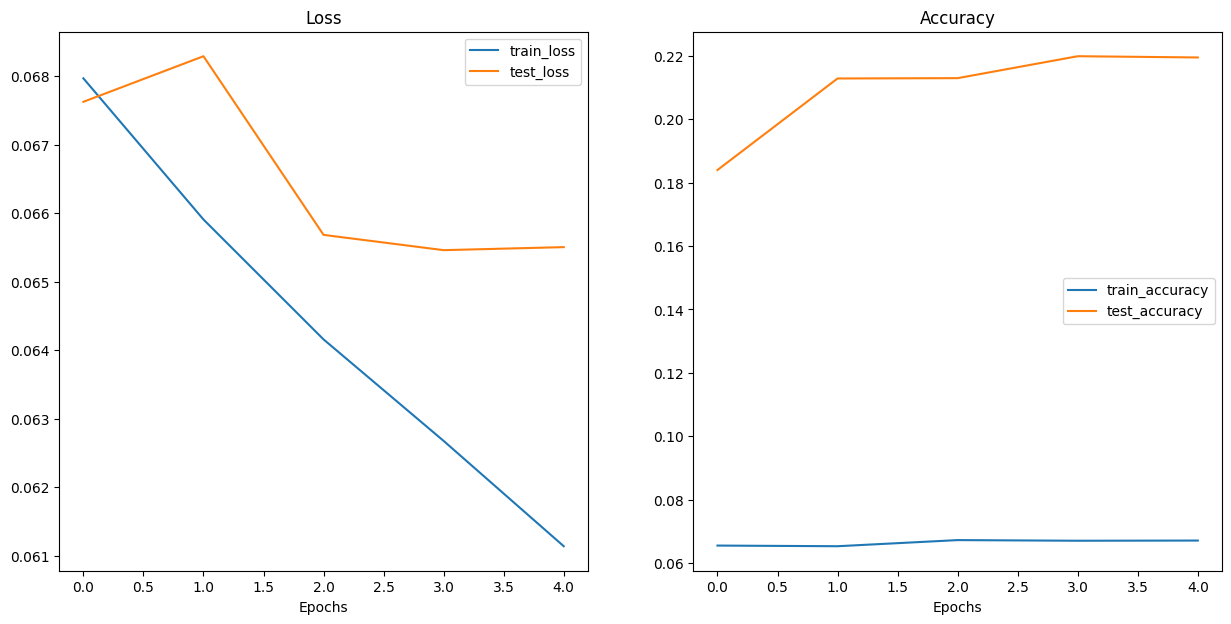

In [12]:
plot_loss_curves(landmark_results)

In [13]:
landmark_model = pd.DataFrame(landmark_results)
landmark_model.to_csv("landmark_model.csv")


In [14]:
import visualization


In [15]:
path = '../saved_images/epoch_2/heatmap_predictions/prueba_batch0.pt'

In [16]:
heatmap  =torch.load(path).cpu()[0]

In [17]:
heatmap.shape

torch.Size([7, 112, 112])

In [18]:
import matplotlib.pyplot as plt

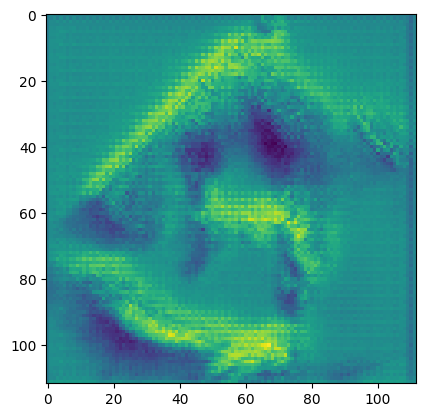

In [22]:
canal = heatmap[1]
plt.imshow(canal)

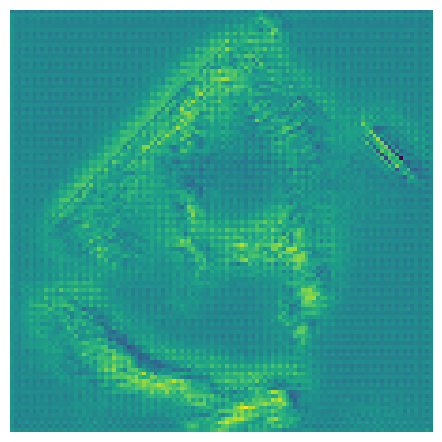

In [20]:
visualization.show_n_channel_image_tensor(heatmap)